# Introduction to Theano

What is Theano? Theano is a method of describing mathematical operations that can be carried out either in Python or by low-level C code on a Graphics Processing Unit (GPU).

## Simple Example

To get started, let's explore a very simple example. Consider the function:

$ f(x, y) = x + y $

In mathematics, we write the function $f$ that takes two parameters, $x$ and $y$. The body of the function is simply $x + y$.

In Python, we would write that as:

In [1]:
def f(x, y):
    return x + y

In [2]:
f(5, 6)

11

In Theano, we use the Python language as a method of writing symbolic expressions. 

First, we import the needed components `T` and `function`:

In [3]:
import theano.tensor as T
from theano import function

Next, we define two symbols, x and y. These are both Python variables and Theano symbols. The quoted 'x' is the Theano symbol, which is assigned to a Python variable of the same name (to make it easier to understand and help during debugging).

In [4]:
x = T.scalar('x')

The term scalar simply means that it has a single value. In Theano, this is sometimes called a zero-dimensional array.

We do the same with y:

In [208]:
y = T.scalar('y')

# or both together:
x, y = T.scalars('x', 'y')

As you can see, the Python variable x is of type TensorVariable.

In [209]:
type(x)

theano.tensor.var.TensorVariable

Next, we define a Theano function. We do this in two steps. First, we describe the body of the function:

In [210]:
func = x + y

This looks like we are adding x and y together. However, we note that x and y are symbols... they do not yet have values.

We can see that func is something very strange:

In [211]:
func

Elemwise{add,no_inplace}.0

The second step in creating a function is to make a Python function. To do this, we use the Theano `function` function. It takes a list of parameters as symbols, followed by the Theano function body:

In [212]:
pyfunc = function(inputs=[x, y], outputs=func)
# or:
# pyfunc = function([x, y], func)

In [213]:
pyfunc

In [214]:
pyfunc(5, 6)

array(11.0)

You can take a Theano function body and show it in symbolic form, perhaps close to the original Python source:

In [215]:
from theano import pp
pp(func)

'(x + y)'

## Matrix Example

This example will use matrices, one of the main uses of Theano.

In this example, we will use T.dmatrix to define a matrix of doubles (floating point values).

In [216]:
a = T.dmatrix('a')
b = T.dmatrix('b')

Again, we define the Theano function, and the Python function:

In [217]:
func = a + b
pyfunc = function([a, b], func)

In [218]:
pyfunc([[1, 2], 
        [3, 4]], 
       [[10, 20],
        [100, 200]])

array([[  11.,   22.],
       [ 103.,  204.]])

The result is given as a numpy ndarray:

In [219]:
result = pyfunc([[1, 2], 
                 [3, 4]], 
                [[10, 20],
                 [100, 200]])

In [220]:
type(result)

numpy.ndarray

You can create matrices composed of:

* 32-bit itegers (i prefix)
* 64-bit integers (l prefix)
* 32-bit floats (f prefix)
* 64-bit floats (d prefix)


## Computing a Derivative

Consider the equation:

$f(x)=e^{sin(x^2)}$

In [222]:
x = T.dscalar('x')

In [223]:
fx = T.exp(T.sin(x**2))

In [224]:
pyfunc = function([x], fx)

In [225]:
pyfunc(10)

array(0.602681965908778)

Does that agree with what we would compute directly in Python?

In [226]:
import math
def eq(x):
    return math.exp(math.sin(x ** 2))
eq(10)

0.602681965908778

Yes, they do agree. 

Let's plot the function using matplotlib.

In [227]:
%matplotlib inline
from matplotlib.pyplot import plot

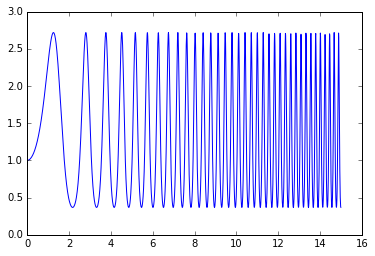

In [228]:
import numpy
plot(numpy.arange(0, 15, .01), 
     [pyfunc(x) for x in numpy.arange(0, 15, .01)])

Now we will compute the derivative of our function. Normally, in regular Python, we would have to solve for the derivative. However, because we have described the function symbolically, Theano can solve for the derivative via the symbols.

To do this, we will use T.grad() with respect to (wrt) x:

In [229]:
fp = T.grad(fx, wrt=x)
fprime = function([x], fp)

In [230]:
fprime(10)

array(10.394080663811636)

Let's plot the derivative of the function:

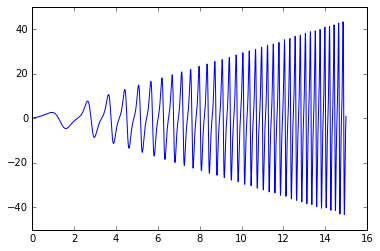

In [231]:
import numpy
plot(numpy.arange(0, 15, .01), 
     [fprime(x) for x in numpy.arange(0, 15, .01)])

## Neural Network: XOR

For this experiment, we will learn the function XOR using back-propagation of error.

First, we import the elements from theano and numpy that we will need:

In [2]:
import theano
import theano.tensor as T
from theano import function, pp
import theano.tensor.nnet as nnet
import numpy as np
import random

In [3]:
%matplotlib inline
from matplotlib.pyplot import plot

Recall XOR:

Input 1 | Input 2 | Target
--------|---------|-------
0 | 0 | 0
0 | 1 | 1
1 | 0 | 1
1 | 1 | 0

That is, given 2 inputs the output is True if either of the inputs is True, but not if both are.

Three layers:

* 2 inputs (+ 1 bias = 3 values)
* 2 hidden units (+ 1 bias = 3 values)
* 1 output unit (1 value)

First we define two Theano symbols for representing the inputs and desired output (called the target).

In [4]:
th_inputs = T.dvector('inputs') # two inputs
th_target = T.dscalar('target') # one target/output

To compute the activation at a layer, we take the inputs * weights to get the net activation, and then apply the sigmoid:

In [5]:
def compute_activation(inputs, weights):
    bias = np.array([1], dtype='float64')
    all_inputs = T.concatenate([inputs, bias])
    net_input = T.dot(weights.T, all_inputs) 
    activation = nnet.sigmoid(net_input)
    return activation

To give you a sense of what compute_activation is, you can see a representation of the computation:

In [6]:
pp(compute_activation(th_inputs, th_target))

'sigmoid((target * join(TensorConstant{0}, inputs, TensorConstant{(1,) of 1.0})))'

What does the sigmoid function return? Let's turn that into a Python function and plot it:

In [7]:
x = T.dscalar('x')          # 64-bit float
fx = nnet.sigmoid(x)        # Theano function

In [8]:
fx

sigmoid.0

In [9]:
pp(fx)

'sigmoid(x)'

In [10]:
sigmoid = function([x], fx) # Python function

In [11]:
sigmoid(.5)

array(0.6224593312018546)

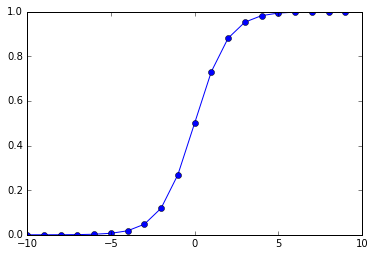

In [12]:
xs = range(-10, 10, 1)
ys = [sigmoid(x) for x in xs]
plot(xs, ys, "o-")

We create a shared variable named epsilon to control the learning rate. The learning rate will typically be in the range 0.9 to 0.01. This value depends on the function being learned.

In [13]:
epsilon = theano.shared(0.1, name='epsilon') # learning rate

Now we define the method to update the weights. We find the derivative with respect to the weights, and subtract that value from the weights.

In [14]:
def compute_delta_weights(compute_error, weights):
    return weights - (epsilon * T.grad(compute_error, wrt=weights))

We define the first set of weights to go between the inputs and the hidden layer. 

In [15]:
NUM_INPUTS = 2
NUM_HIDDENS = 2
NUM_OUTPUTS = 1

The initial random weights are created to span from -1 to 1. 

In [16]:
def make_weights(ins, outs):
    return np.array(2 * np.random.rand(ins + 1, outs) - 1,
                  dtype='float64')

In [17]:
weights1 = theano.shared(make_weights(NUM_INPUTS, NUM_HIDDENS),
                         name='weights1')

In [18]:
hidden_layer = compute_activation(th_inputs, weights1) 

We can test the hidden_layer Theano function by turning it into a Python function, and calling it with [0, 0] bound to th_inputs:

In [19]:
function([th_inputs], hidden_layer)([0, 0])

array([ 0.70860966,  0.59814888])

In [20]:
weights2 = theano.shared(make_weights(NUM_HIDDENS, NUM_OUTPUTS), 
                         name='weights2') # 4 x 1

In [21]:
output_layer = T.sum(compute_activation(hidden_layer, weights2)) # Theano function

In [22]:
compute_error = (output_layer - th_target) ** 2  # Theano function

We can test the entire Theano equation now by calling compute_error with values for th_inputs and th_target:

In [23]:
function([th_inputs, th_target], compute_error)([0, 0], 0)

array(0.1820956722056817)

Finally, we can create a Python function (called train) that will call compute_error, and update the weights:

In [24]:
train = function(
    inputs=[th_inputs, th_target], 
    outputs=compute_error, 
    updates=[(weights1, compute_delta_weights(compute_error, weights1)),
             (weights2, compute_delta_weights(compute_error, weights2))])

Ok, now we are ready to train a neural network to perform the XOR function.

In [25]:
inputs = [[0, 1],
          [1, 0],
          [1, 1],
          [0, 0]]

def xor(a, b):
    return int((a or b) and not(a and b))

for pattern in inputs:
    print(pattern, xor(*pattern))

[0, 1] 1
[1, 0] 1
[1, 1] 0
[0, 0] 0


We simply call `train()` on each of the input/target pairs:

In [26]:
def train_all(epochs=5000):
    for e in range(epochs):
        random.shuffle(inputs)
        for i in range(len(inputs)):
            target = xor(*inputs[i])
            error = train(inputs[i], target) 
        if (e + 1) % 500 == 0 or e == 0: 
            print('Epoch:', e + 1, 'error:', error)

In [27]:
%%time
train_all()

Epoch: 1 error: 0.17590230024029582
Epoch: 500 error: 0.21345970272465195
Epoch: 1000 error: 0.12049236516936544
Epoch: 1500 error: 0.058610122233544594
Epoch: 2000 error: 0.021417091129154138
Epoch: 2500 error: 0.009440614304426448
Epoch: 3000 error: 0.00704809674144815
Epoch: 3500 error: 0.0040809552182693035
Epoch: 4000 error: 0.0026386841665036777
Epoch: 4500 error: 0.0027368789131071805
Epoch: 5000 error: 0.002107508288249151
CPU times: user 3.96 s, sys: 0 ns, total: 3.96 s
Wall time: 3.96 s


In [28]:
test = function([th_inputs], output_layer)

In [29]:
test([0, 0])

array(0.04786447075736276)

In [30]:
test([0, 1])

array(0.9468603709518669)

In [31]:
test([1, 0])

array(0.9541607426531297)

In [32]:
test([1, 1])

array(0.04242692545605788)

To train another network, we need to reinitialize the weights:

In [35]:
NUM_HIDDENS = 5

In [36]:
weights1.set_value(make_weights(NUM_INPUTS, NUM_HIDDENS)) 
weights2.set_value(make_weights(NUM_HIDDENS, NUM_OUTPUTS)) 

We could also try a different learning rate:

In [37]:
epsilon.set_value(0.05)

In [38]:
%%time
train_all()

Epoch: 1 error: 0.5129482764713498
Epoch: 500 error: 0.27343068436219553
Epoch: 1000 error: 0.26608887763525896
Epoch: 1500 error: 0.23315802349319936
Epoch: 2000 error: 0.27206627125525334
Epoch: 2500 error: 0.14440235701111373
Epoch: 3000 error: 0.06289470998854373
Epoch: 3500 error: 0.032000729577620186
Epoch: 4000 error: 0.02204097166832901
Epoch: 4500 error: 0.014695800522454913
Epoch: 5000 error: 0.010053228953848652
CPU times: user 3.96 s, sys: 0 ns, total: 3.96 s
Wall time: 3.97 s


In [39]:
for pattern in inputs:
    print(pattern, test(pattern))

[0, 0] 0.08647435393170991
[1, 1] 0.10474032896915239
[0, 1] 0.89557766834058
[1, 0] 0.9001455909520547


## Generalization

Although we only trained on the corners, we can see what 

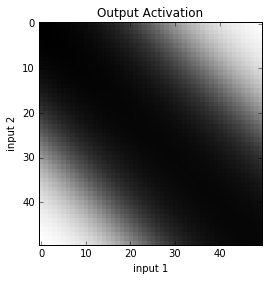

In [40]:
import matplotlib.pyplot as plt

res = 50 # resolution
z = np.zeros((res, res))

for x in range(res):
    for y in range(res):
        z[x][y] = test([x/res, y/res])

plt.imshow(z, cmap=plt.cm.gray, interpolation='nearest')
plt.xlabel("input 1")
plt.ylabel("input 2")
plt.title("Output Activation")

plt.show()

# Handwriting Categorization

First, I'll use the metakernel's %download magic to get the MNIST hand written data:

In [140]:
! pip install metakernel --user -U

Requirement already up-to-date: metakernel in /home/dblank/.local/lib/python3.4/site-packages
Requirement already up-to-date: IPython>=3.0 in /usr/local/lib/python3.4/dist-packages (from metakernel)
Requirement already up-to-date: prompt-toolkit<2.0.0,>=1.0.3 in /usr/local/lib/python3.4/dist-packages (from IPython>=3.0->metakernel)
Requirement already up-to-date: pygments in /usr/local/lib/python3.4/dist-packages (from IPython>=3.0->metakernel)
Requirement already up-to-date: pickleshare in /usr/local/lib/python3.4/dist-packages (from IPython>=3.0->metakernel)
Requirement already up-to-date: simplegeneric>0.8 in /usr/lib/python3/dist-packages (from IPython>=3.0->metakernel)
Requirement already up-to-date: traitlets>=4.2 in /usr/local/lib/python3.4/dist-packages (from IPython>=3.0->metakernel)
Requirement already up-to-date: setuptools>=18.5 in /usr/local/lib/python3.4/dist-packages (from IPython>=3.0->metakernel)
Requirement already up-to-date: pexpect; sys_platform != "win32" in /usr/

In [141]:
import metakernel

In [142]:
metakernel.register_ipython_magics()

In [42]:
%download http://deeplearning.net/data/mnist/mnist.pkl.gz

Downloaded 'mnist.pkl.gz'.


Unzip the file:

In [43]:
!gunzip mnist.pkl.gz

From http://deeplearning.net/tutorial/gettingstarted.html we see that:

> The pickled file represents a tuple of 3 lists: the training set, the validation set and the testing set. Each of the three lists is a pair formed from a list of images and a list of class labels for each of the images. An image is represented as numpy 1-dimensional array of 784 (28 x 28) float values between 0 and 1 (0 stands for black, 1 for white). The labels are numbers between 0 and 9 indicating which digit the image represents.

We read the Python2 pickled data:

In [44]:
import pickle
import gzip
import numpy

with open('mnist.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data = u.load()
    train_set, validation_set, test_set = data

In [45]:
len(train_set)

2

In [46]:
len(train_set[0])

50000

In [47]:
len(train_set[0][0])

784

In [58]:
epsilon.set_value(0.1)

In [75]:
weights1.set_value(make_weights(784, 100))
weights2.set_value(make_weights(100, 1))

In [70]:
inputs = [train_set[0][i] for i in range(len(train_set[0]))]
targets = [train_set[1][i]/9.0 for i in range(len(train_set[0]))]

In [61]:
def display_digit(vector):
    for r in range(28):
        for c in range(28):
            v = int(vector[r * 28 + c] * 10)
            ch = " .23456789"[v]
            print(ch, end="")
        print()

In [62]:
for i in range(10):
    display_digit(inputs[i])
    print(int(targets[i] * 9))

                            
                            
                            
                            
                            
                456.6994    
        ..36699999869972    
       .99999999993332.     
        8999997799          
        364998  .6          
           693              
           597              
            792             
            .9864           
             39994          
              .7995.        
                3997        
                 9992       
              .57998        
            .5899997        
           48999973         
         28999973           
       68999973             
    268999995               
    5999855                 
                            
                            
                            
5
                            
                            
                            
                            
               .696.        
              .99999        
            

In [76]:
def train_digits(max_epochs=1000):
    epoch = 0
    correct = 0
    total = 1
    while correct/total < 1.0 and epoch < max_epochs:
        total = 0
        correct = 0
        for i in range(100):
            target = targets[i]
            error = train(inputs[i], target)
            output = test(inputs[i])
            target = int(targets[i] * 9)
            total += 1
            if int(output * 10) == target:
                correct += 1
        if (epoch + 1) % 10 == 0 or epoch == 0: 
            print('Epoch:', epoch + 1, 'error:', error, "% correct:", correct/total)
        epoch += 1

In [77]:
train_digits()

Epoch: 1 error: 0.005584251108050222 % correct: 0.35
Epoch: 10 error: 0.0029438254302019415 % correct: 0.63
Epoch: 20 error: 0.006812425881126288 % correct: 0.82
Epoch: 30 error: 0.007693440417472783 % correct: 0.86
Epoch: 40 error: 0.007743773335648142 % correct: 0.87
Epoch: 50 error: 0.007499984180644583 % correct: 0.87
Epoch: 60 error: 0.006956871273104968 % correct: 0.88
Epoch: 70 error: 0.006286300074310477 % correct: 0.91
Epoch: 80 error: 0.005599327283432899 % correct: 0.94
Epoch: 90 error: 0.004935531392142657 % correct: 0.94
Epoch: 100 error: 0.004342748344285977 % correct: 0.94
Epoch: 110 error: 0.003883171178634236 % correct: 0.95
Epoch: 120 error: 0.0035272259137190546 % correct: 0.96
Epoch: 130 error: 0.003215317224888725 % correct: 0.96
Epoch: 140 error: 0.0029190018730087764 % correct: 0.96
Epoch: 150 error: 0.0026268698087645796 % correct: 0.96
Epoch: 160 error: 0.0023347309948372526 % correct: 0.96
Epoch: 170 error: 0.002042928231895698 % correct: 0.96
Epoch: 180 error

In [78]:
for i in range(100):
    output = test(inputs[i])
    target = int(targets[i] * 9)
    print("target:", target, "output:", output, "correct?", int(output * 10) == target)

target: 5 output: 0.5556280926515031 correct? True
target: 0 output: 0.00696529248487226 correct? True
target: 4 output: 0.44446910241180626 correct? True
target: 1 output: 0.11612437994607885 correct? True
target: 9 output: 0.9812517793933981 correct? True
target: 2 output: 0.22215165403428155 correct? True
target: 1 output: 0.11598203822154937 correct? True
target: 3 output: 0.3346167813701906 correct? True
target: 1 output: 0.11068877997250166 correct? True
target: 4 output: 0.44540500886593215 correct? True
target: 3 output: 0.3341170831349773 correct? True
target: 5 output: 0.5568792499273469 correct? True
target: 3 output: 0.33388551837641745 correct? True
target: 6 output: 0.6672638401988485 correct? True
target: 1 output: 0.10927842752617704 correct? True
target: 7 output: 0.7789229615036498 correct? True
target: 2 output: 0.2225713705572802 correct? True
target: 8 output: 0.8908189428421025 correct? True
target: 6 output: 0.6677248922319263 correct? True
target: 9 output: 0.97

<h1>References</h1>

1. http://outlace.com/Beginner-Tutorial-Theano/
2. http://deeplearning.net/software/theano/tutorial/adding.html
